In [1]:
#import our models 
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,log_loss
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier , LogisticRegression , RidgeClassifier, Lasso, ElasticNet, Ridge, BayesianRidge 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings , string
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
warnings.filterwarnings('ignore')
import joblib

#seeding 
np.random.seed(0)

#load the data
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sub = pd.read_csv('SampleSubmission.csv')

In [2]:
# check the shape of the data
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (5151, 3)
test shape: (1288, 2)


In [3]:
# sample our data 
train.sample(3)

,id,content,category
3567,SW4996,Ameyasema hayo baada ya Baraza la Sanaa la Ta...,michezo
3636,SW5072,WAZIRI MKUU Kassim Majaliwa ameitaka menejime...,Kitaifa
3390,SW4799,WANAFUNZI zaidi ya 500 wanaosoma katika Shule...,Kitaifa


In [4]:
#check how many categories we have
train['category'].value_counts()


category
Kitaifa      2000
michezo      1720
Biashara     1360
Kimataifa      54
Burudani       17
Name: count, dtype: int64

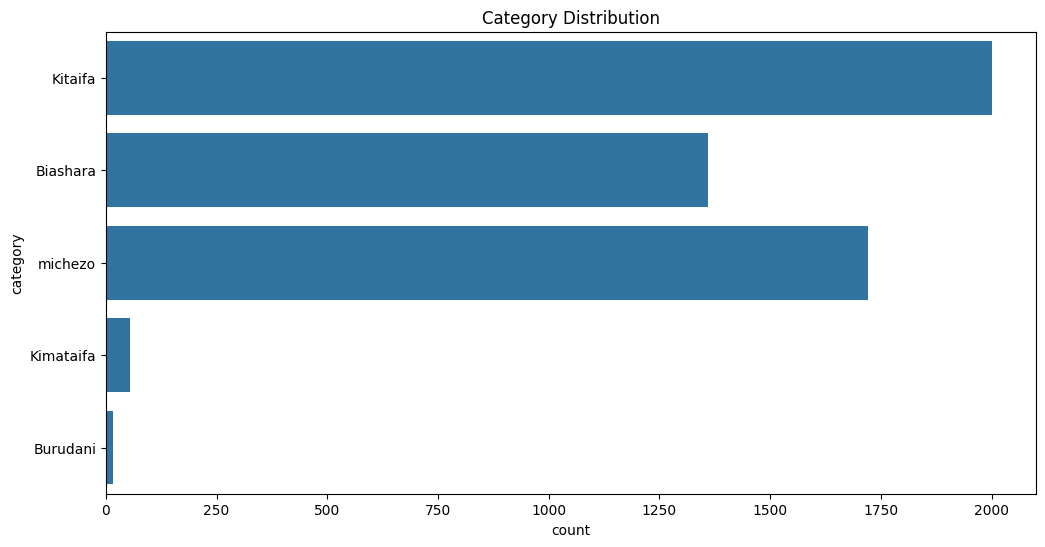

In [5]:
#plot category distribution
plt.figure(figsize=(12,6))
sns.countplot(train['category'])
plt.title('Category Distribution')
plt.show()


In [6]:
#check for missing values
train.isnull().sum()

id          0
content     0
category    0
dtype: int64

In [7]:
# data processing
# a mapping dictionary that maps the category values from 0 to 5
category_mapping = {
"Kitaifa": 0,
"Biashara": 1,
"michezo": 2,
"Kimataifa": 3,
"Burudani": 4
}

train["category"] = train.category.map(category_mapping)


In [8]:
#calculate word count for each text
train['word_count'] = train['content'].apply(lambda x: len(x.split()))

#Calculate average word length
train['avg_word_length'] = train['content'].apply(lambda x: np.mean([len(word) for word in x.split()]))


#Calculate word count for each text
test['word_count'] = test['content'].apply(lambda x: len(x.split()))

#Calculate average word length
test['avg_word_length'] = test['content'].apply(lambda x: np.mean([len(word) for word in x.split()]))

In [9]:
sw_stopwords=["akasema","alikuwa","alisema","baada","basi","bila","cha","chini","hadi",
              "hapo","hata","hivyo","hiyo","huku","huo","ili","ilikuwa","juu","kama","karibu",
              "katika","kila","kima","kisha","kubwa","kutoka","kuwa","kwa","kwamba","kwenda","kwenye","la","lakini",
              "mara","mdogo","mimi","mkubwa","mmoja","moja","muda","mwenye","na","naye","ndani","ng","ni","nini",
              "nonkungu","pamoja","pia","sana","sasa","sauti","tafadhali","tena","tu","vile","wa",
              "wakati","wake","walikuwa","wao","watu","wengine","wote","ya","yake","yangu","yao","yeye","yule","za",
              "zaidi","zake","na","ya","wa","kwa","ni","za","katika","la","kuwa","kama","kwamba","cha","hiyo","lakini","yake","hata","wakati",
              "hivyo","sasa","wake","au","watu","hii","zaidi","vya","huo","tu","kwenye","si","pia","ili","moja","kila","baada","ambao","ambayo","yao","wao","kuna",
              "hilo","kutoka","kubwa","pamoja","bila","huu","hayo","sana","ndani","mkuu","hizo","kufanya","wengi","hadi","mmoja","hili","juu","kwanza","wetu","kuhusu",
              "baadhi","wote","yetu","hivi","kweli","mara","wengine","nini","ndiyo","zao","kati","hao","hapa","kutokana","muda","habari","ambaye","wenye","nyingine","hakuna",
              "tena","hatua","bado","nafasi","basi","kabisa","hicho","nje","huyo","vile","yote","mkubwa","alikuwa","zote","leo","haya","huko","kutoa","mwa","kiasi","hasa","nyingi","kabla","wale","chini","gani","hapo","lazima","mwingine","bali","huku","zake","ilikuwa",
              "tofauti","kupata","mbalimbali","pale","kusema","badala","wazi","yeye","alisema","hawa",
              "ndio","hizi","tayari","wala","muhimu","ile","mpya","ambazo","dhidi","kwenda","sisi","kwani",
              "jinsi","binafsi","kutumia","mbili","mbali","kuu","mengine","mbele","namna","mengi","upande","na","lakini","ingawa"
              "ingawaje","kwa","sababu","hadi","hata","kama","ambapo","ambamo","ambako","ambacho","ambao","ambaye","ilhali","ya","yake","yao","yangu","yetu","yenu","vya","vyao","vyake","vyangu",
"vyenu","vyetu","yako","yao","hizo","yenu","mimi","sisi","wewe","nyinyi","yeye","wao","nao","nasi","nanyi","ni","alikuwa","atakuwa","hii","hizi","zile",
"ile","hivi","vile","za","zake","zao","zenu","kwenye","katika","kwa","kwao","kwenu","kwetu","dhidi","kati","miongoni","katikati","wakati","kabla","baada",
"baadaye","nje","tena","mbali","halafu","hapa","pale","mara","mara","yoyote","wowote","chochote","vyovyote","yeyote","lolote","mwenye","mwenyewe","lenyewe",
"lenye","wote","lote","vyote","nyote","kila","zaidi","hapana","ndiyo","au","ama","ama","sio","siye","tu","budi","nyingi","nyingine","wengine","mwingine",
"zingine","lingine","kingine","chote","sasa","basi","bila","cha","chini","hapo","pale","huku","kule","humu","hivyo","hivyohivyo","vivyo","palepale","fauka",
"hiyo","hiyohiyo","zile","zilezile","hao","haohao","huku","hukuhuku","humuhumu","huko","hukohuko","huo","huohuo","hili","hilihili","ilikuwa","juu","karibu",
"kila","kima","kisha","kutoka","kwenda","kubwa","ndogo","kwamba","kuwa","la","lao","lo","mara","na",
"mdogo","mkubwa","ng’o","pia","aidha","vile","vilevile","kadhalika","halikadhalika","ni","sana","pamoja","pamoja","tafadhali","tena",
"wa","wake","wao",
"ya","yule","wale","zangu","nje","afanaleki","salale","oyee","yupi","ipi","lipi","ngapi","yetu","si","angali","wangali","loo","la","ohoo",
"barabara","oyee",
"ewaa","walahi","masalale","duu","toba","mh","kumbe","ala","ebo","haraka","pole","polepole","harakaharaka","hiyo","hivyo","vyovyote",
"atakuwa","itakuwa","mtakuwa",
"tutakuwa","labda","yumkini","haiyumkini","yapata","takribani","hususani","yawezekana","nani","juu""chini",
"ndani","baadhi","kuliko","vile","mwa","kwa","hasha","hivyo","moja","kisha",
"pili","kwanza","ili","je","jinsi","ila","ila","nini","hasa","huu","zako","mimi",
]

In [10]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(' ', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text


# Applying the cleaning function to both test and training datasets
train['content'] = train['content'].apply(lambda x: clean_text(x))
test['content'] = test['content'].apply(lambda x: clean_text(x))

In [11]:
def remove_err(text):
    text = text.replace('â€™', "")
    text = text.replace('â€œ', "")
    text = text.replace('â€', "")
    text = text.replace('â€˜', "")
    text = text.replace('â€”', "")
    text = text.replace('â€“', "")
    text = text.replace('â€¢', "")
    text = text.replace('â€¦', "")
    text = re.sub(r'^â€˜(.*?)â€™$', '', text)
    text = re.sub(r'^â€œ(.*?)â€', '', text)
    return text


# Applying the cleaning function to both test and training datasets
train['content'] = train['content'].apply(lambda x: remove_err(x))
test['content'] = test['content'].apply(lambda x: remove_err(x))


In [12]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['content'] = train['content'].apply(lambda x: tokenizer.tokenize(x))
test['content'] = test['content'].apply(lambda x: tokenizer.tokenize(x))
train['content'].head()

0    [serikaliimesemahaitakuwatayarikuonaamaninautu...
1    [mkuuwamkoawataboraaggreymwanriamesitishalikiz...
2    [serikaliimetoamiezisitakwataasisizotezaummaam...
3    [kampuniyamchezowakubahatishayambetimeingiamak...
4    [watanzaniawamekumbushwakusherehekeasikukuuyak...
Name: content, dtype: object

In [13]:
def remove_stopwords(text):
    """
    Removing stopwords belonging to swahili language
    
    """
    words = [w for w in text if w not in sw_stopwords]
    return words

train['content'] = train['content'].apply(lambda x : remove_stopwords(x))
test['content'] = test['content'].apply(lambda x : remove_stopwords(x))

In [14]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text
train['content']=train['content'].apply(lambda x: combine_text(x))
test['content'] = test['content'].apply(lambda x : combine_text(x))

In [15]:
train.sample(3)

,id,content,category,word_count,avg_word_length
4693,SW6268,katikapromoshenihiyoiliyoanzamwishonimwanovemb...,1,221,5.687783
763,SW1864,kwakaulimojahalmashaurikuuyataifanecyachamacha...,0,661,5.452345
159,SW1184,asasizakiraiazimesemalichayamuswadawasheriawav...,0,497,5.599598


In [16]:
train.fillna(0 , inplace=True)
test.fillna(0 , inplace=True)

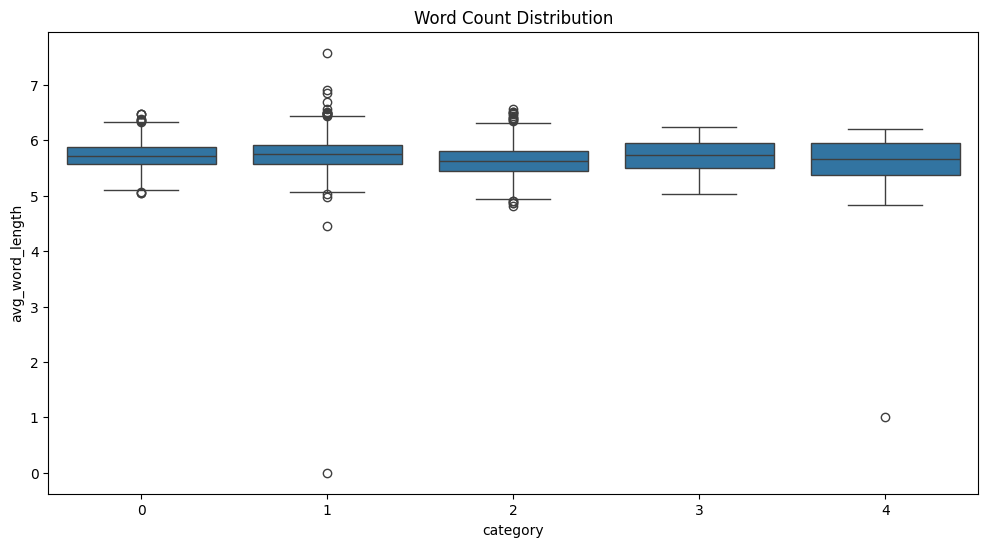

In [17]:
#check the distribution of the word count in comparison to the category
plt.figure(figsize=(12,6))
sns.boxplot(x='category', y='avg_word_length', data=train)
plt.title('Word Count Distribution')
plt.show()


In [18]:
tfidf = TfidfVectorizer(min_df=15, max_df=0.5, ngram_range=(1, 2),norm='l2',sublinear_tf=True)
train_vectors = tfidf.fit_transform(train['content'])
test_vectors = tfidf.transform(test["content"])

In [19]:
# Concatenate TF-IDF vectors with new features
X_train_combined = hstack((train_vectors, train[['word_count', 'avg_word_length']].values))
X_test_combined = hstack((test_vectors, test[['word_count', 'avg_word_length']].values))

In [20]:
#split features and target from train data 
X = X_train_combined
y = train.category.values

In [21]:
#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
#list of models to use
models = [
    {"model": LogisticRegression(), "name": "Logistic Regression"},
    {"model": DecisionTreeClassifier(), "name": "Decision Tree Classifier"},
    {"model": RandomForestClassifier(), "name": "RandomForestClassifier"},
    {"model": MultinomialNB(), "name": "MultinomialNB"},
    {"model": XGBClassifier(), "name": "XGBClassifier"},
    {"model": LGBMClassifier(), "name": "LGBMClassifier"},
    {"model": CatBoostClassifier(), "name": "CatBoostClassifier"},

    ]

In [23]:
# Initialize an empty list to store results
results = []

# Iterate through the list of models
for model_entry in models:
    model = model_entry['model']
    model_name = model_entry['name']
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate accuracy and log loss
    accuracy = accuracy_score(y_test, y_pred)
    log_loss_score = log_loss(y_test, y_pred_proba)
    
    # Append results to the list
    results.append({'Model': model_name, 'Accuracy': accuracy, 'Log Loss': log_loss_score})

# Convert the list of results to a DataFrame
df_models = pd.DataFrame(results)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 4120, number of used features: 3
[LightGBM] [Info] Start training from score -0.935899
[LightGBM] [Info] Start training from score -1.331512
[LightGBM] [Info] Start training from score -1.111314
[LightGBM] [Info] Start training from score -4.516946
[LightGBM] [Info] Start training from score -5.615558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Learning rate set to 0.085052
0:	learn: 1.5430947	total: 162ms	remaining: 2m 41s

In [24]:
df_models

,Model,Accuracy,Log Loss
0,Logistic Regression,0.473327,1.082326
1,Decision Tree Classifier,0.368574,22.591210
2,RandomForestClassifier,0.426770,1.717496
3,MultinomialNB,0.464597,1.085505
4,XGBClassifier,0.441319,1.174398
5,LGBMClassifier,0.457808,1.158589
6,CatBoostClassifier,0.478177,1.094701


In [25]:
df_models.to_csv('model_performance.csv', index=False)

## Log Loss 
Log loss, also known as logarithmic loss or cross-entropy loss, is a commonly used evaluation metric in multiclass classification tasks. It measures the performance of a classification model by penalizing incorrect classifications. Log loss quantifies the accuracy of a classifier by measuring the uncertainty of its predictions. Lower log loss values indicate better performance, with zero representing perfect predictions.

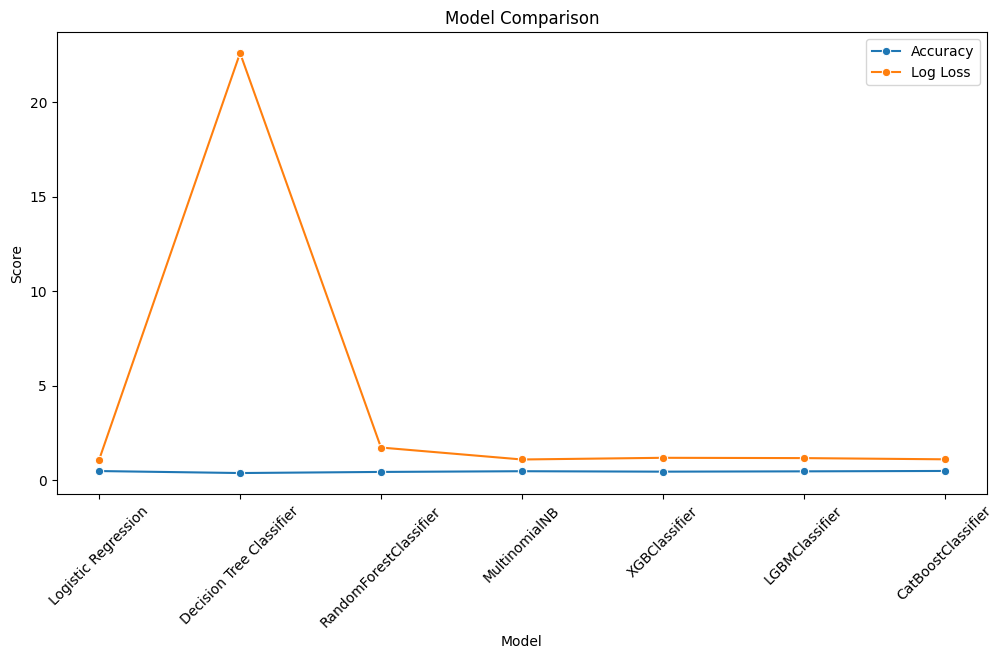

In [26]:
#plot the results for both accuracy and log loss
plt.figure(figsize=(12,6))
sns.lineplot(data=df_models, x='Model', y='Accuracy', marker='o', label='Accuracy')
sns.lineplot(data=df_models, x='Model', y='Log Loss', marker='o', label='Log Loss')
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()



Logistic regression performed relatively well together with Catboost Classifier and MultinomialNB .
Further tuning and experimentation with the models could improve the performance .

In [27]:
#Blend the three models :CatBoostClassifier ,Logistic Regression and MultinoialNB
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[
    ('catboost', CatBoostClassifier(verbose=False)), 
    ('logistic', LogisticRegression()), 
    ('nb', MultinomialNB())], voting='soft')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
log_loss_score = log_loss(y_test, y_pred_proba)

print('Accuracy:', accuracy)
print('Log Loss:', log_loss_score)



Accuracy: 0.49660523763336567
Log Loss: 1.0605662674460423


In [28]:
from sklearn.model_selection import GridSearchCV

# Create CatBoostClassifier instance
catboost = CatBoostClassifier(verbose=False)

# Define hyperparameter grid
param_grid_catboost = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100]
}

# Perform GridSearchCV
clf_catboost = GridSearchCV(estimator=catboost, param_grid=param_grid_catboost, n_jobs=-1, cv=3, verbose=2)
clf_catboost.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters for CatBoostClassifier:", clf_catboost.best_params_)


best_params = clf_catboost.best_params_
catboost = CatBoostClassifier(**best_params, verbose=False)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
y_pred_proba = catboost.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
log_loss_score = log_loss(y_test, y_pred_proba)
print('Accuracy:', accuracy)
print('Log Loss:', log_loss_score)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best hyperparameters for CatBoostClassifier: {'depth': 8, 'iterations': 100, 'learning_rate': 0.01}
Accuracy: 0.498545101842871
Log Loss: 1.2152196647207092


In [29]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression instance
logistic = LogisticRegression()

# Define hyperparameter grid
param_grid_logistic = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2']
}

# Perform GridSearchCV
clf_logistic = GridSearchCV(estimator=logistic, param_grid=param_grid_logistic, n_jobs=-1, cv=3, verbose=2)
clf_logistic.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters for Logistic Regression:", clf_logistic.best_params_)


best_params = clf_logistic.best_params_

logistic = LogisticRegression(**best_params)
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)
y_pred_proba = logistic.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)

log_loss_score = log_loss(y_test, y_pred_proba)
print('Accuracy:', accuracy)
print('Log Loss:', log_loss_score)


Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best hyperparameters for Logistic Regression: {'C': 100.0, 'penalty': 'l2'}
Accuracy: 0.4742967992240543
Log Loss: 1.082298906373824


In [30]:
from sklearn.naive_bayes import MultinomialNB

# Create MultinomialNB instance
nb = MultinomialNB()

# Define hyperparameter grid
param_grid_nb = {
    'alpha': [0.5, 1.0, 2.0]
}

# Perform GridSearchCV
clf_nb = GridSearchCV(estimator=nb, param_grid=param_grid_nb, n_jobs=-1, cv=3, verbose=2)
clf_nb.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters for MultinomialNB:", clf_nb.best_params_)


best_params = clf_nb.best_params_

nb = MultinomialNB(**best_params)
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
y_pred_proba = nb.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
log_loss_score = log_loss(y_test, y_pred_proba)

print('Accuracy:', accuracy)
print('Log Loss:', log_loss_score)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best hyperparameters for MultinomialNB: {'alpha': 2.0}
Accuracy: 0.463627546071775
Log Loss: 1.0862997131202257


In [31]:
# ensemble using stacking 
from sklearn.ensemble import StackingClassifier

# Create a list of base models
estimators = [
    ('catboost', CatBoostClassifier(verbose=False)),
    ('logistic', LogisticRegression()),
    ('nb', MultinomialNB())
]

# Create StackingClassifier instance
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=3)
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)
y_pred_proba = stacking.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
log_loss_score = log_loss(y_test, y_pred_proba)

print('Accuracy:', accuracy)
print('Log Loss:', log_loss_score)



Accuracy: 0.486905916585839
Log Loss: 1.0571303857920897


In [32]:

joblib.dump(stacking, 'stacking_model.pkl')
joblib.dump(model,"voting_model.pkl")


['voting_model.pkl']

In [33]:
shapc= "menejamawasilianonauteteziwaasasiyaagpahiamefarikiduniagaflabaadayakuangukaakiwakatikashughulizakezakikazihukokahamashinyangaleoagpahiniasasiyakiraiainayojishughulishanamapambanodhidi"